In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
%matplotlib inline

In [2]:
def convert_timezone(date, dst_tz, src_tz='GMT', date_fmt='%a, %d %b %Y %H:%M:%S GMT', output='date'):
    import pytz
    from datetime import datetime
    if isinstance(date, str):
        D = datetime.strptime(date, date_fmt)
    else:
        D = date
    src = pytz.timezone(src_tz)
    dst = pytz.timezone(dst_tz)
    D = src.localize(D).astimezone(dst)
    if output == 'date':
        return D
    return D.strftime(date_fmt).replace(src_tz, dst_tz)


def make_dataframe(data):
    if data['pilotSignal'] is None:
        raise Exception('No pilot signal')
    tz = data['timezone']
    df1 = pd.DataFrame(data=data['pilotSignal'])
    df1['timestamps'] = df1['timestamps'].apply(convert_timezone, args=(tz,))
    df1['timestamps'] = pd.to_datetime(df1['timestamps'])
    df2 = pd.DataFrame(data=data['chargingCurrent'])
    df2['timestamps'] = df2['timestamps'].apply(convert_timezone, args=(tz,))
    df2['timestamps'] = pd.to_datetime(df2['timestamps'])
    return pd.merge(df1, df2, how='inner', on=['timestamps'])


def convert_to_hour_of_day(times, weekdays):
    hours = []
    for day in range(7):
        idx, = np.where(weekdays == day)
        hours.append(np.array([times[i].hour * 3600 + 
                               times[i].minute * 60 +
                               times[i].second for i in idx]) / 3600)
    return hours


def plot_times(hours, bin_size=0.5, ax=None, **kwargs):
    edges = np.r_[0 : 24 + bin_size/2 : bin_size]
    if ax is None:
        _,ax = plt.subplots(1, 1, figsize=(10,5))
    for i,hrs in enumerate(hours):
        n,_ = np.histogram(hrs, bins=edges)
        ax.bar(i * 24 + edges[:-1], n, width=bin_size, align='edge', **kwargs)
    step = 6
    ax.set_xticks(np.r_[0 : 24*7+1 : step])
    ax.set_xticklabels(np.arange(0, 24*7+1, step) % 24)

### Load the data

In [3]:
data_file = os.path.join('..', 'EV_data_station_with_ts_2019.json')
data_file = os.path.join('..', 'EV_data_2019_kWh_0-100.json')
data = json.load(open(data_file, 'r'))
n_recordings = len(data)
print(f'There are {n_recordings} recordings.')

There are 10609 recordings.


In [4]:
data[0].keys()

dict_keys(['_id', 'userInputs', 'sessionID', 'stationID', 'spaceID', 'siteID', 'clusterID', 'connectionTime', 'disconnectTime', 'kWhDelivered', 'doneChargingTime', 'timezone', 'userID'])

In [5]:
connection_times = [convert_timezone(d['connectionTime'], d['timezone']) for d in data]
disconnection_times = [convert_timezone(d['disconnectTime'], d['timezone']) for d in data]
done_charging_times = [convert_timezone(d['doneChargingTime'], d['timezone']) \
                       if d['doneChargingTime'] is not None else None for d in data]
missing_charging_times, = np.where([t is None for t in done_charging_times])
kWh_delivered = np.array([d['kWhDelivered'] for d in data])
connection_dur = np.array([(end-start).seconds / 3600 \
                           for start,end in zip(connection_times, disconnection_times)])
n_missing = len(missing_charging_times)
frac_missing = n_missing / n_recordings
week_days = np.array([d.weekday() for d in connection_times])
working_days = week_days < 5
connection_hours = convert_to_hour_of_day(connection_times, week_days)
disconnection_hours = convert_to_hour_of_day(disconnection_times, week_days)
print(f'{n_missing} recordings ({frac_missing*100:.1f}%) do not have the final charging time.')

466 recordings (4.4%) do not have the final charging time.


### The distributions of connection durations, delivered amounts of energy and duration vs. delivered  energy

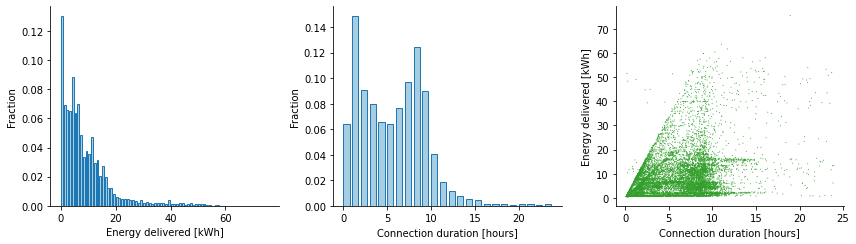

In [6]:
fig,ax = plt.subplots(1, 3, figsize=(12, 3.5))

cmap = plt.get_cmap('Paired')
facecol = cmap(0)
edgecol = cmap(1)

bin_size = 1 # kWh
edges = np.r_[0 : kWh_delivered.max() + bin_size/2 : bin_size]
n,_ = np.histogram(kWh_delivered, bins=edges, density=True)
ax[0].bar(edges[:-1], n, width=0.7*bin_size, align='edge',
       facecolor=facecol, edgecolor=edgecol, linewidth=1)
ax[0].set_xlabel('Energy delivered [kWh]')
ax[0].set_ylabel('Fraction')

bin_size = 1 # hours
edges = np.r_[0 : connection_dur.max() + bin_size/2  : bin_size]
n,_ = np.histogram(connection_dur, bins=edges, density=True)
ax[1].bar(edges[:-1], n, width=0.7*bin_size, align='edge',
       facecolor=facecol, edgecolor=edgecol, linewidth=1)
ax[1].set_xlabel('Connection duration [hours]')
ax[1].set_ylabel('Fraction')

ax[2].scatter(connection_dur, kWh_delivered, s=1, color=cmap(3), marker='o', edgecolors='none')
ax[2].set_xlabel('Connection duration [hours]')
ax[2].set_ylabel('Energy delivered [kWh]')

for a in ax:
    for side in 'right','top':
        a.spines[side].set_visible(False)
fig.tight_layout()


### Plot the distributions of (dis)connection times for each day of the week

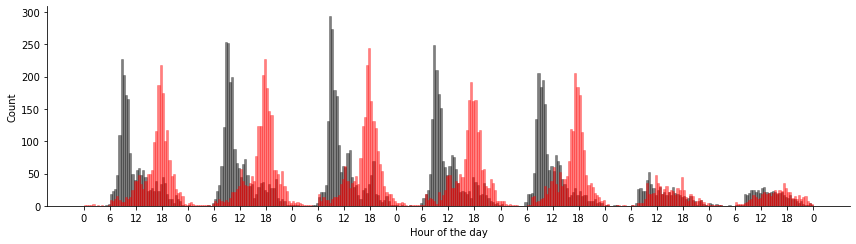

In [7]:
fig,ax = plt.subplots(1, 1, figsize=(12,3.5))
plot_times(connection_hours, ax=ax, facecolor='k', edgecolor='k', lw=0.5, alpha=0.5)
plot_times(disconnection_hours, ax=ax, facecolor='r', edgecolor='r', lw=0.5, alpha=0.5)
for side in 'right','top':
    ax.spines[side].set_visible(False)
ax.set_ylabel('Count')
ax.set_xlabel('Hour of the day')
fig.tight_layout()

### Fit the arrivals time of a single day with an exponential distribution (i.e.,  Poisson arrival times)

In [8]:
day = 0
hrs = connection_hours[day]
IEIs = np.diff(hrs)                # [hours] inter-event intervals
IEIs = IEIs[IEIs > 0] * 60         # [minutes]
bin_size = 5                       # [minutes]
edges = np.r_[0 : np.ceil(IEIs.max() / 60) * 60 : bin_size]
n,edges = np.histogram(IEIs, bins=30)
bin_size = edges[1] - edges[0]
fit_func = lambda t,a,b: a*np.exp(b*t)
x = edges[:-1] + bin_size/2
y = n
(a,b),_ = curve_fit(fit_func, x, y, p0=[y[0], -1/np.median(IEIs)])

print(f'Mean arrival time: {IEIs.mean():.1f} min.')
print(f'Median arrival time: {np.median(IEIs):.1f} min.')
print(f'Mean arrival time of the fitted distribution: {1/np.abs(b):.1f} min.')
print('Expected mean arrival time (if uniform distr.): ' +
      f'{365 * 24 * 60 / 7 / connection_hours[day].size:.1f} min.')

Mean arrival time: 23.8 min.
Median arrival time: 10.8 min.
Mean arrival time of the fitted distribution: 12.6 min.
Expected mean arrival time (if uniform distr.): 42.1 min.


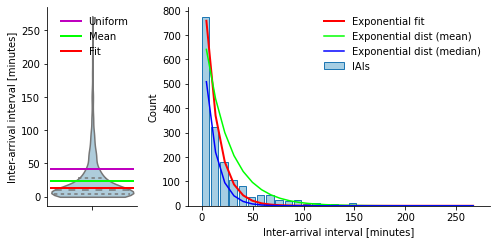

In [9]:
fig = plt.figure(figsize=(7,3.5))
gs = GridSpec(1, 7, fig)
ax = [fig.add_subplot(gs[0,:2]), fig.add_subplot(gs[0,2:])]

sns.violinplot(y=IEIs, ax=ax[0], cut=0, inner='quartile', color=facecol, linewidth=1.5)
ax[0].plot([-0.4, 0.4], 365 * 24 * 60 / 7 / connection_hours[day].size + np.zeros(2),
           'm', lw=2, label='Uniform')
ax[0].plot([-0.4, 0.4], IEIs.mean() + np.zeros(2), color=[0,1,0], lw=2, label='Mean')
ax[0].plot([-0.4, 0.4], 1 / np.abs(b) + np.zeros(2), color=[1,0,0], lw=2, label='Fit')
ax[0].legend(loc='best', frameon=False)

ax[1].bar(edges[:-1], n, width=0.8*bin_size, align='edge',
       facecolor=facecol, edgecolor=edgecol, linewidth=1, label='IAIs')
ax[1].plot(x, fit_func(x, a, b), 'r', lw=2, label='Exponential fit')
ax[1].plot(x, fit_func(x, y[0], -1/IEIs.mean()), color=[0,1,0], label='Exponential dist (mean)')
ax[1].plot(x, fit_func(x, y[0], -1/np.median(IEIs)), color=[0,0,1], label='Exponential dist (median)')
for axx in ax:
    for side in 'right','top':
        axx.spines[side].set_visible(False)

ax[0].set_ylabel('Inter-arrival interval [minutes]')
ax[1].set_xlabel('Inter-arrival interval [minutes]')
ax[1].set_ylabel('Count')
ax[1].legend(loc='upper right', frameon=False)
fig.tight_layout()

In [10]:
if 'pilotSignal' in data[0]:
    with_ts = True
    print('Time series data present.')
else:
    with_ts = False
    print('Time series data missing.')

Time series data missing.


### Convert the data to a list of dataframes

In [11]:
if with_ts:
    df = []
    for i,d in enumerate(data):
        sys.stdout.write('.')
        try:
            out = make_dataframe(d)
            df.append(out)
        except Exception as exc:
            if exc.args[0] != 'No pilot signal':
                raise exc
        if (i+1) % 50 == 0:
            sys.stdout.write('\n')
    print(f'{len(data)-len(df)} entries out of {len(data)} ' + 
          f'({(len(data)-len(df))/len(data)*100:.1f}%) had no pilot signal.')

### Plot the time series of the pilot signal and actual delivered current

In [12]:
if with_ts:
    fig = plt.figure(figsize=(12,8))
    gs = GridSpec(2, 2, fig)
    ax = [fig.add_subplot(gs[0,:]), fig.add_subplot(gs[1,:1]), fig.add_subplot(gs[1,1:])]
    for i,d in enumerate(df):
        lgnd = True if i == 0 else False
        d.plot(x='timestamps', y='current', ax=ax[0], color='k', lw=1, legend=lgnd)
        d.plot(x='timestamps', y='pilot', ax=ax[0], color='r', lw=1, legend=lgnd)
        ax[0].plot(d.loc[0,'timestamps'], 35, '*', color='k', markersize=5)
    for i,n in enumerate((0, 14)):
        df[n].plot(x='timestamps', y='current', ax=ax[i+1], color='k', lw=1, legend=False)
        df[n].plot(x='timestamps', y='pilot', ax=ax[i+1], color='r', lw=1, legend=False)
        ax[i+1].set_ylim(ax[0].get_ylim())
    for a in ax:
        for side in 'right','top':
            a.spines[side].set_visible(False)
        a.set_xlabel('Time')
    ax[0].set_ylabel('Current [A]')
    ax[1].set_ylabel('Current [A]')
    fig.tight_layout()